# Bike Sharing in Washington D.C. with Dask

Two datasets from [Bike Sharing in Washington D.C.](https://www.kaggle.com/marklvl/bike-sharing-dataset/home) containing information about the Bike Sharing service in Washington D.C. "Capital Bikeshare" are provided.

One dataset contains hourly data and the other one has daily data from the years 2011 and 2012.

The following variables are included in the data:

* instant: Record index
* dteday: Date
* season: Season (1:springer, 2:summer, 3:fall, 4:winter)
* yr: Year (0: 2011, 1:2012)
* mnth: Month (1 to 12)
* hr: Hour (0 to 23, only available in the hourly dataset)
* holiday: whether day is holiday or not (extracted from Holiday Schedule)
* weekday: Day of the week
* workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit: (extracted from Freemeteo)
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered (Our target variable)

We will build a predictive model that can determine how many people will use the service on an hourly basis. We will use the first 5 quarters of the data for our training dataset and the last quarter of 2012 will be the holdout against which we perform our validation. Since that data was not used for training, we are sure that the evaluation metric that we get for it (R2 score) is an objective measurement of its predictive power.

### Outline

We separate the project in 3 steps:

Data Loading and Exploratory Data Analysis: Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

Feature Engineering / Pipeline and Hyperparameter Tuning: Once we have the data, we create some features and then create a pipeline with different transformers, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

Results and Conclusions: Finally, with our tuned model, we  predict against the test set we decided to separate initially, then we review those results against their actual values to determine the performance of the model, and finally, outlining our conclusions.

In [1]:
import seaborn as sns
import dask.dataframe as dd
from sklearn.base import clone
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from dask.distributed import Client
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from dask_ml.model_selection import RandomizedSearchCV
from dask_ml.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed.

In [2]:
PATH = 'https://gist.githubusercontent.com/akoury/af59a34ac7d3eb52fd78d6ead200f224/raw/f034e9dc2d2f62d82bbc685e499e48968b9db064/Bicycles.csv'
SPLITS = 4
METRIC = 'r2'
SEED = 1
TARGET = 'cnt'

### The Dataset

The necessary data was uploaded to a gist from where its read directly by Dask.

**Optionally** (because it requires more setup) you may download the data directly from Kaggle, this is the optimal way since you are sure to obtain the latest files if there are any changes.

In order to obtain the data from Kaggle using its API, you need to:
1. Install the kaggle package ```pip install kaggle```
2. [Create a Kaggle account](https://www.kaggle.com/account/login) if you do not have one
3. Create a Kaggle API key in your account section
4. Add the kaggle.json file that was created in step 3 to a folder called .kaggle located in your user folder

In [3]:
# import kaggle
# import zipfile

# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('marklvl/bike-sharing-dataset', path='data', unzip=False)

Zipfile is required to unzip the kaggle file (since the unzip parameter in the ```dataset_download_files``` method is not working [Issue #158](https://github.com/Kaggle/kaggle-api/issues/158)).

In [4]:
# zipper = zipfile.ZipFile('data/bike-sharing-dataset.zip', 'r')
# zipper.extractall('data/')
# zipper.close()
# PATH = 'data/hour.csv'

Here we create the necessary Dask distributed client, you may click on the dashboard link to see the task stream and additional information.

In [5]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:51418 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


### Data Loading

Here we load the necessary data, print its first rows and describe its contents.

Since our dataset is small and we want to take advantage of the distributed capabilities of Dask, we set a blocksize of 300KB which distributes our code in 4 partitions.

In [6]:
types = {
    'season':'category',
    'yr':'category', 
    'mnth': 'category',
    'holiday' :'bool',
    'weekday': 'category',
    'workingday':'bool',
    'weathersit':'category',
}

df = dd.read_csv(PATH, parse_dates=[1], dtype=types, blocksize="300KB")
df.npartitions

4

### Precipitation Data and Preparation
We will add precipitation data obtained from the [National Climatic Data Center.](https://www.ncdc.noaa.gov/cdo-web/datasets)

However, since most of the values are 0, we will convert them to a boolean that determines if rain was present or not at that specific hour.

We also categorize the categorical features and set the date as the index.

In [7]:
precipitation = dd.read_csv("https://gist.githubusercontent.com/akoury/6fb1897e44aec81cced8843b920bad78/raw/b1161d2c8989d013d6812b224f028587a327c86d/precipitation.csv", parse_dates=[1])
df = dd.merge(df, precipitation, how="left", on=["dteday", "hr"])
df['precipitation'] = df['precipitation'].mask(df['precipitation'].isnull(), 0).mask(df['precipitation'] > 0, 1).astype(bool)
df = df.set_index('dteday')
df.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,precipitation
dteday,,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0,3,13,16,True
2011-01-01,2,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0,8,32,40,True
2011-01-01,3,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0,5,27,32,True
2011-01-01,4,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0,3,10,13,True
2011-01-01,5,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0,0,1,1,True


**Note:** head() only grabs values from the first partition, so it is not an expensive operation

Since we set the date as the index for the Dask Dataframe, each division will be sorted according to its date

In [8]:
df.divisions

(Timestamp('2011-01-01 00:00:00'),
 Timestamp('2011-06-16 13:26:24'),
 Timestamp('2011-12-24 00:00:00'),
 Timestamp('2012-06-18 05:02:59.828612352'),
 Timestamp('2012-12-31 00:00:00'))

### Data Types

We review the data types for each column.

In [9]:
df.dtypes

instant             int64
season           category
yr               category
mnth             category
hr                  int64
holiday              bool
weekday          category
workingday           bool
weathersit       category
temp              float64
atemp             float64
hum               float64
windspeed         float64
casual              int64
registered          int64
cnt                 int64
precipitation        bool
dtype: object

### Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model.

Because we are working in a distributed way with a supposedly large dataset, we will take a random sample of 15% of the dataset to visualize it.

In [10]:
sample = df.sample(frac=0.15, replace=True, random_state=SEED)

### Overall distribution of the target variable

Here we see the distribution in the number of users in the sample per hour

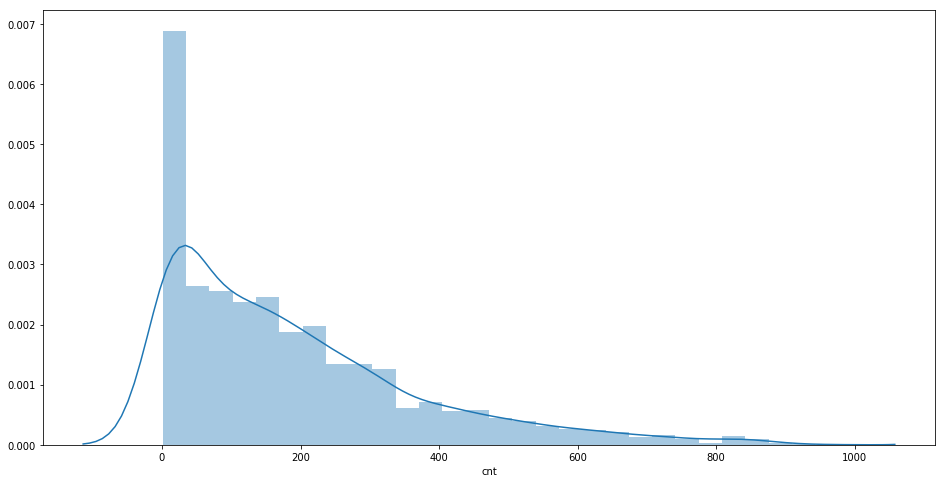

In [11]:
plt.figure(figsize=(16, 8))
sns.distplot(sample[TARGET])

### Usage per hour of the day by registered and casual users

Here we can see usage per hour differing between registered users and casual users.

We can assume that most of the registered users use the service to get to work/school, therefore peak hours are in the morning and in the afternoon, meanwhile, casual users do not have any big peaks.

Text(0, 0.5, 'Users')

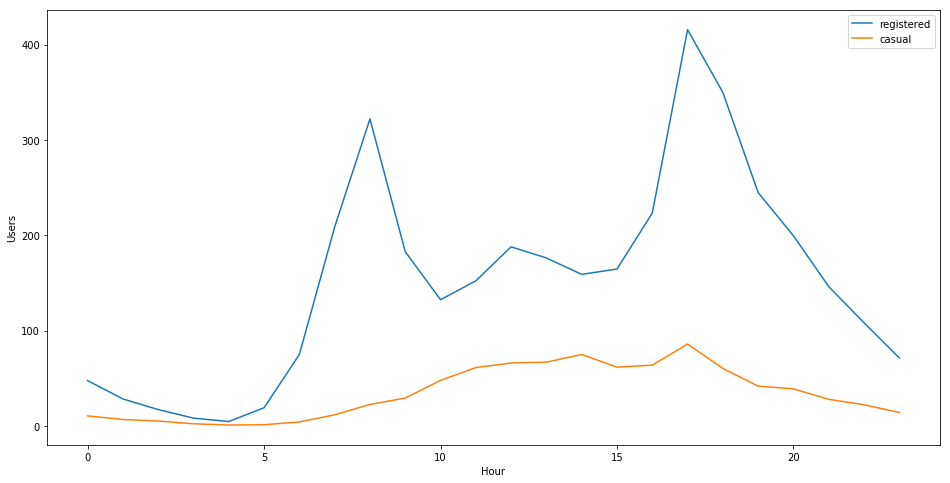

In [12]:
plt.figure(figsize=(16, 8))
grouped = sample.groupby('hr').agg({'registered': 'mean', 'casual': 'mean'}).reset_index().compute()
sns.lineplot(data=grouped, x="hr", y="registered", palette="husl", label="registered")
sns.lineplot(data=grouped, x="hr", y="casual", palette="husl", label="casual")
plt.xlabel("Hour")
plt.ylabel("Users")

### Usage per month by registered and casual users

Here we can see usage per month, the colder months are the ones with least usage and the summer months have the most usage.

Text(0, 0.5, 'Users')

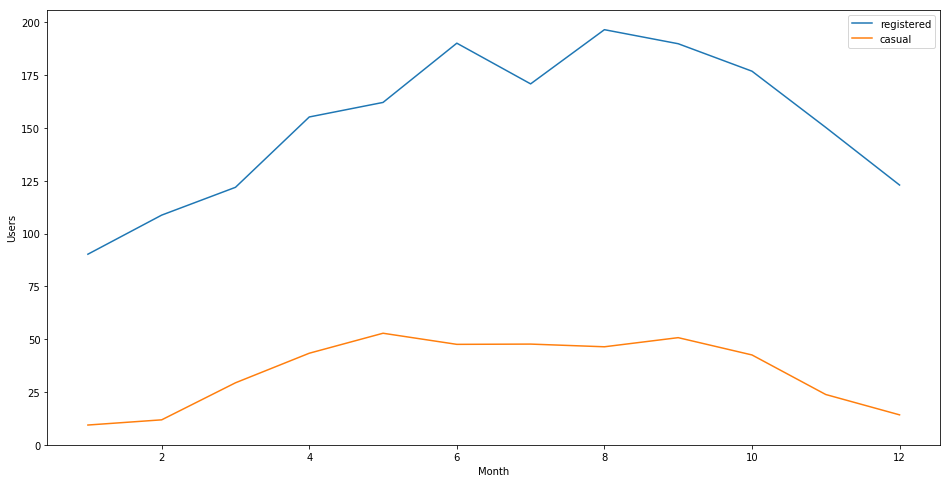

In [13]:
plt.figure(figsize=(16, 8))
sample['mnth'] = sample['mnth'].astype('int')
grouped = sample.groupby('mnth').agg({'registered': 'mean', 'casual': 'mean'}).reset_index().compute()
sns.lineplot(data=grouped, x="mnth", y="registered", palette="husl", label="registered")
sns.lineplot(data=grouped, x="mnth", y="casual", palette="husl", label="casual")
plt.xlabel("Month")
plt.ylabel("Users")

### Usage per day of the week by registered and casual users

Here we can see usage per day of the week.

For registered users, usage goes down during the weekend days and up during the working days, while for casual users is the contrary

Text(0, 0.5, 'Users')

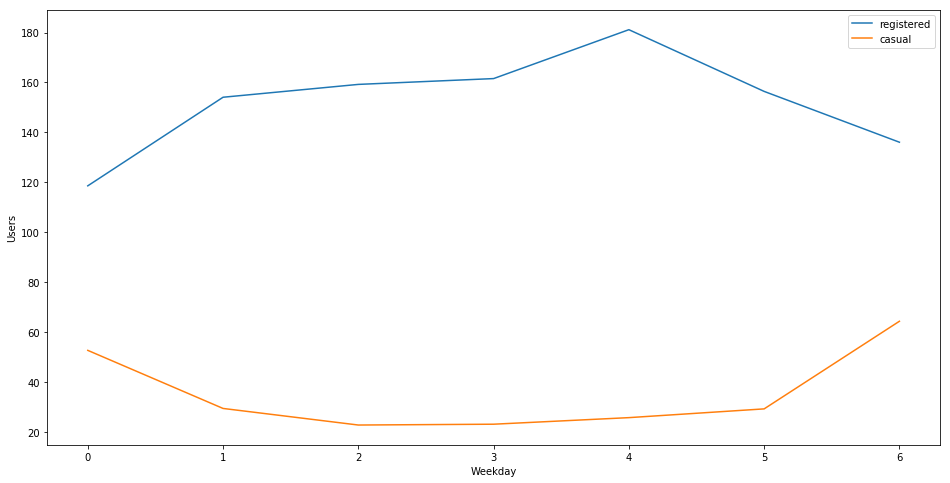

In [14]:
plt.figure(figsize=(16, 8))
sample['weekday'] = sample['weekday'].astype('int')
grouped = sample.groupby('weekday').agg({'registered': 'mean', 'casual': 'mean'}).reset_index().compute()
sns.lineplot(data=grouped, x="weekday", y="registered", palette="husl", label="registered")
sns.lineplot(data=grouped, x="weekday", y="casual", palette="husl", label="casual")
plt.xlabel("Weekday")
plt.ylabel("Users")

### Boxplot of Numerical Variables

We review the distribution of numerical data through a boxplot for each variable.

Some features have many outliers, therefore some sort of scaling and skewness fixing may be of use.

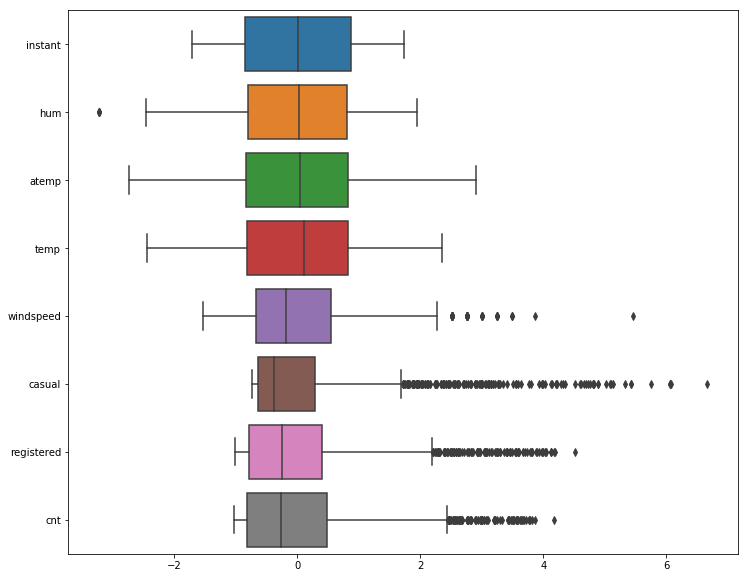

In [15]:
plt.figure(figsize=(12, 10))
numeric = sample[["instant", "hum", "atemp", "temp", "windspeed", "casual", "registered", "cnt"]].compute()
numeric = (numeric - numeric.mean()) / numeric.std()
sns.boxplot(data=numeric, orient="h")

### Data Correlation

Now we will analyze correlation in the data for all variables.

From this we see that 'temp' and 'atemp' are highly correlated as well as 'season' and 'month' therefore we will remove one variable of each group

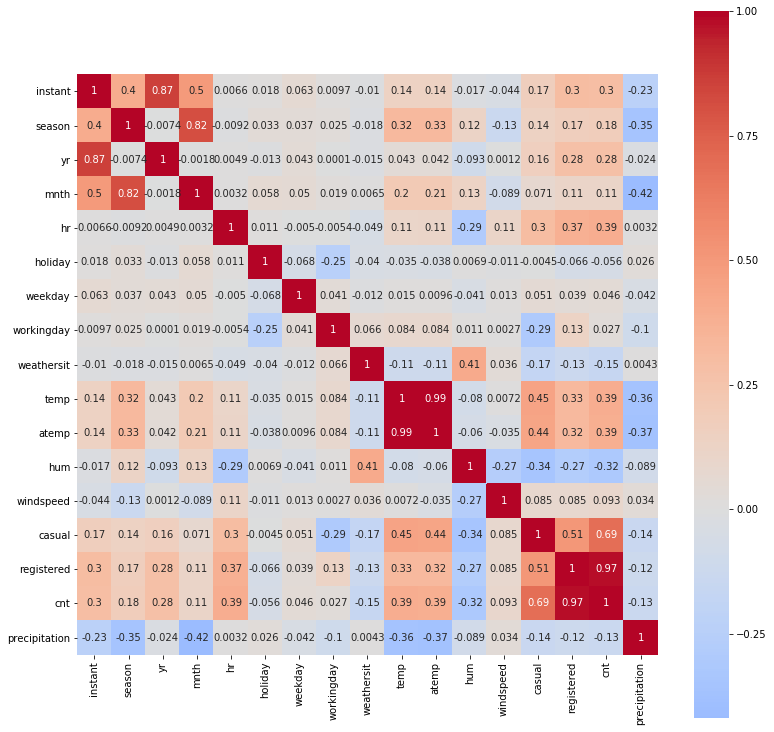

In [16]:
plt.figure(figsize=(13, 13))
sns.heatmap(sample.astype(float).corr(), cmap='coolwarm', center=0, square=True, annot=True, xticklabels=sample.columns, yticklabels=sample.columns)

### Feature Engineering

#### Is Late
We add a boolean to determine if it is late during the day or not, since we see from the visualizations that usage varies greatly

In [17]:
df['is_late'] = (df['hr'] > 20) | (df['hr'] < 6)

### Train/Test Split
Now we take the last quarter of the data as our testing set and the remaining rows as our training set.

We also drop the columns dteday because we do not need the date, casual and registered since they make up the target variable and correlated columns.

In [18]:
df = df.drop(['season', 'atemp', 'casual', 'registered'], axis=1)
df['hr'] = df['hr'].astype('category')
df = df.categorize()
train_df = df.loc[:'2012-09-30']
holdout = df.loc['2012-10-01':]

### Pipeline Creation
We create the pipeline that will be used for our data.

Initially it standardizes the data and fixes its skewness, then it one-hot encodes the categorical variables and finally it runs it through a model.

The models from the Dask library did not work in the pipeline see relevant issues for [logistic regression](https://github.com/dask/dask-ml/issues/84) and [xgboost](https://github.com/dask/dask-xgboost/issues/31) therefore only models from sklearn and xgboost directly were used. The RandomizedSearchCV does come from Dask, which is the important part for the distribution of tasks.

In [19]:
num_pipeline = Pipeline([
    ("power_transformer", PowerTransformer(method="yeo-johnson", standardize=True)),
])

categorical_pipeline = Pipeline(
    [("one_hot", OneHotEncoder())]
)

pipe = Pipeline([
    ("column_transformer", ColumnTransformer([
        ("numerical_pipeline", num_pipeline, ["instant", "hum", "temp", "windspeed"]),
        ("categorical_pipeline", categorical_pipeline, ["yr", "mnth", "hr", "weekday", "weathersit"]),
    ], remainder="passthrough")),
])

### Scoring with Hyperparameter Tuning
A model is added to the pipeline which is then inserted to a RandomizedSearchCV which cross validates a grid of parameters with a time series split, in order to choose the best ones.

To begin we split X and y.

In [20]:
X = train_df.drop([TARGET], axis=1)
y = train_df[TARGET]

### Fit function
This function will be used by the different pipelines to see the best performing one, it acceps the data, the pipe, the final model and its grid

In [21]:
def fit(X, y, pipe, model, grid):
    pipe = clone(pipe)
    pipe.steps.append(model)
    gridpipe = RandomizedSearchCV(pipe, grid, n_iter=100, cv=TimeSeriesSplit(n_splits=SPLITS), scoring=METRIC, random_state = SEED)
    
    gridpipe.fit(X,y)
    
    print("Model: " + str(model[0]))
    
    print("Best Parameters: " + str(gridpipe.best_params_))
    print("Best Fold Score: " + str(gridpipe.best_score_))
    
    return gridpipe

### Linear Regression

In [22]:
model = ("linear_reg", LinearRegression())

grid = {
    "linear_reg__normalize": [True, False],
    "linear_reg__fit_intercept": [True, False],
}

lr_pipe = fit(X, y, pipe, model, grid)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Model: linear_reg
Best Parameters: {'linear_reg__fit_intercept': True, 'linear_reg__normalize': False}
Best Fold Score: -1.314566226295216e+21


### XGBoost

In [23]:
model = ("xgb", XGBRegressor(random_state = SEED))

grid = {
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.1, 0.2],
    "xgb__n_estimators": [100, 200]
}

xgb_gridpipe = fit(X, y, pipe, model, grid)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Model: xgb
Best Parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
Best Fold Score: 0.7965287112297804


### Random Forest

In [24]:
model = ("random_forest", RandomForestRegressor(n_estimators=100, random_state=SEED)) 

grid = {
    "random_forest__max_depth": [80, 100],
    "random_forest__min_samples_leaf": [3, 5],
    "random_forest__min_samples_split": [5, 10],
    "random_forest__max_leaf_nodes": [None, 30],
}

rf_gridpipe = fit(X, y, pipe, model, grid)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Model: random_forest
Best Parameters: {'random_forest__max_depth': 80, 'random_forest__max_leaf_nodes': None, 'random_forest__min_samples_leaf': 5, 'random_forest__min_samples_split': 5}
Best Fold Score: 0.7419873314343485


### Results
Now we select the best tuned model which is XGB, and with it, make a prediction on the holdout data and obtain its metrics.

In [30]:
final_pipe = xgb_gridpipe
X_test = holdout.drop([TARGET], axis=1)
y_test = holdout[TARGET]

predicted = final_pipe.predict(X_test)
scores = {}
scores['R2'] = r2_score(y_test, predicted)
scores['MAE'] = mean_absolute_error(y_test, predicted)
scores['MSE'] = mean_squared_error(y_test, predicted)
scores

{'R2': 0.7917912843499025, 'MAE': 60.918200611284625, 'MSE': 8460.957054078975}

## Plots of Predictions

Here we plot the different results obtained.

For this scatter plot, the straighter the diagonal line is, the better the predictions since they are closer to the actual values.

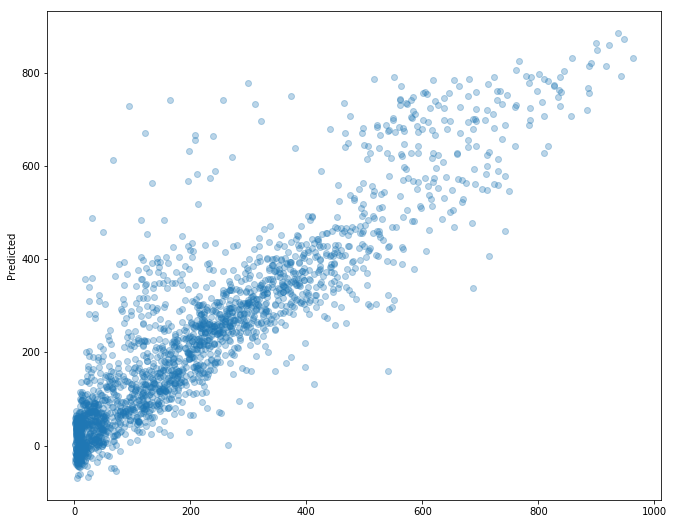

In [26]:
y_test = y_test.compute()
plt.figure(figsize=(11, 9))
plt.scatter(y_test, predicted, alpha=0.3)
plt.ylabel("Predicted")
plt.show()

### Entire daily predictions vs. reality plot

Doing dictionary comprehension to avoid adding numpy or pandas as dependencies

Text(0, 0.5, 'Users')

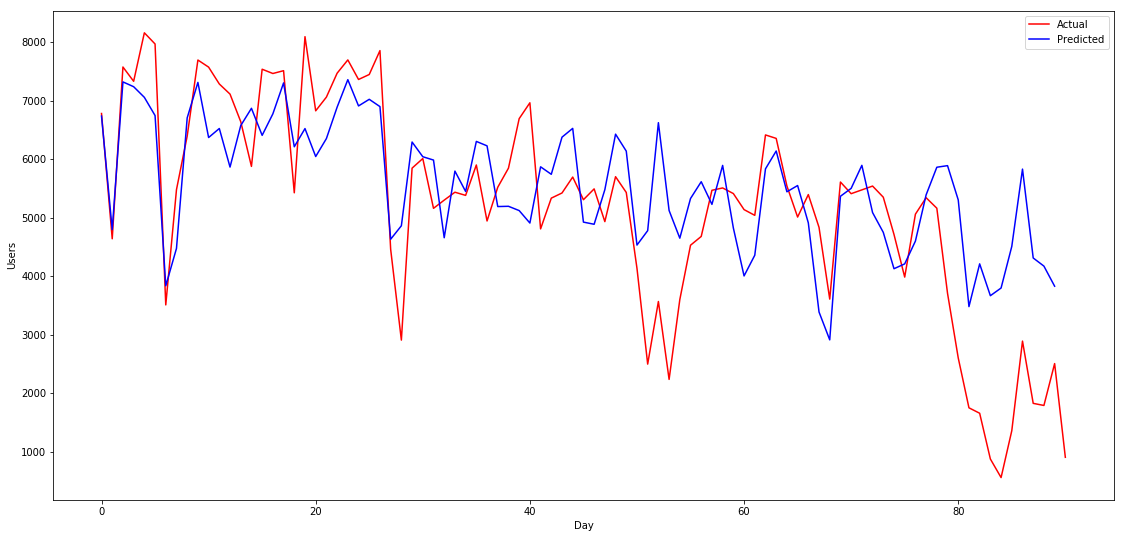

In [28]:
y_test=y_test.reset_index(drop=True)
predicted = {i: predicted[24*i:(24*i)+24].sum() for i in range(len(predicted)//24)}

plt.figure(figsize=(19, 9))
ax = sns.lineplot(data=y_test.groupby(y_test.index // 24).sum(), color="red", label="Actual")
ax = sns.lineplot(list(predicted.keys()), list(predicted.values()), color="blue", label="Predicted")
plt.xlabel("Day")
plt.ylabel("Users")

# Conclusions

We created a model that, based on certain parameters, determine bike usage on an hourly basis, with these results we can provide an estimation of usage which can be of great importance for all of the involved parties.

One of the key findings is that there is a great difference in usage from weekends to normal working days and in usage throught the day depending on registered and casual users, this situation needs to be considered by the company to supply the correct amount of bicicles depending on the day and time of the week, since the demand changes drastically. Then, as can be guessed, temperature plays a big role in usage, although it is more significant in casual users.

After performing multiple data preparation steps and transformations with different tuned models, we finally choose the best performing one on trained data and we obtain our predictions, we can see from them that the model follows along many of the peaks and valleys of the real data.

Many different bike-sharing companies accross the world could use this model to estimate bike usage, planify better for expected demand and even help their governments transportation requirements. Measuring the impact of new bike infrastructure on cycling traffic and behavior is top of mind for many planners and advocacy groups.

As for Dask usage, we see great improvements in terms of speed, which make working in a distributed fashion very easy. Furthermore, it seems like the library is continually improving, currently there are multiple issues that need to be tackled in order to ensure correct funtionality across the board but its future is promising as a good distributed and familiar alternative to pandas, without having to tackle Spark.

In [31]:
client.close()